🔧 Optimizing parameters...
Iter 1: PnL = 1575.50 | window = 19.9, entry = 0.84, exit = 0.60
Iter 2: PnL = 2037.00 | window = 19.8, entry = 0.71, exit = 0.68
Iter 3: PnL = 2165.00 | window = 19.7, entry = 0.64, exit = 0.85
Iter 4: PnL = 2417.50 | window = 19.7, entry = 0.70, exit = 1.02
Iter 5: PnL = 2782.00 | window = 19.5, entry = 0.61, exit = 1.07
Iter 6: PnL = 2814.00 | window = 19.3, entry = 0.57, exit = 1.09
Iter 7: PnL = 2838.00 | window = 19.1, entry = 0.44, exit = 1.11
Iter 8: PnL = 2794.00 | window = 19.2, entry = 0.42, exit = 1.29
Iter 9: PnL = 2830.50 | window = 19.3, entry = 0.46, exit = 1.10
Iter 10: PnL = 2795.50 | window = 19.4, entry = 0.40, exit = 1.22
Iter 11: PnL = 2892.50 | window = 19.5, entry = 0.22, exit = 1.22
Iter 12: PnL = 2726.50 | window = 19.5, entry = 0.42, exit = 1.25
Iter 13: PnL = 2829.00 | window = 19.7, entry = 0.36, exit = 1.17
Iter 14: PnL = 2896.00 | window = 19.5, entry = 0.21, exit = 1.15
Iter 15: PnL = 2715.00 | window = 19.5, entry = 0.40, exit

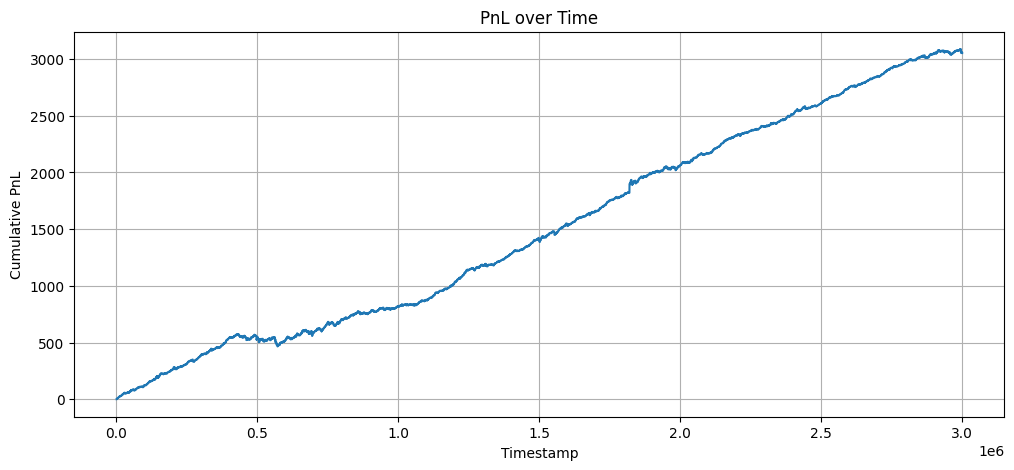

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 📊 Load data
# --------------------------
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = [col.lower().strip() for col in df.columns]
    if 'timestamp' not in df or 'price' not in df:
        raise ValueError("CSV must have 'timestamp' and 'price' columns.")
    return df[['timestamp', 'price']]

# --------------------------
# 🧠 Z-score calculation
# --------------------------
def compute_z_score(series, window):
    if len(series) < window:
        return 0
    mean = series[-window:].mean()
    std = series[-window:].std()
    return (series.iloc[-1] - mean) / std if std > 0 else 0

# --------------------------
# 🔁 Backtest strategy
# --------------------------
def backtest_strategy(prices, window, entry_threshold, exit_threshold):
    position = 0  # -1 short, 0 flat, +1 long
    entry_price = 0
    pnl = 0
    pnl_over_time = []

    for t in range(window, len(prices)):
        z = compute_z_score(prices[:t + 1], window)

        # Entry
        if position == 0:
            if z > entry_threshold:
                position = -1
                entry_price = prices.iloc[t]
            elif z < -entry_threshold:
                position = 1
                entry_price = prices.iloc[t]

        # Exit
        elif position == 1 and z > -exit_threshold:
            pnl += prices.iloc[t] - entry_price
            position = 0
        elif position == -1 and z < exit_threshold:
            pnl += entry_price - prices.iloc[t]
            position = 0

        pnl_over_time.append(pnl)

    return pnl, pnl_over_time

# --------------------------
# ⚙️ Optimize Parameters
# --------------------------
def optimize_parameters(prices, iterations=50, lr=0.2):
    window = 20
    entry_threshold = 1.0
    exit_threshold = 0.5

    for i in range(iterations):
        base_pnl, _ = backtest_strategy(prices, int(window), entry_threshold, exit_threshold)

        # Small epsilon for derivative approximation
        dw = (backtest_strategy(prices, int(window + 1), entry_threshold, exit_threshold)[0] - base_pnl)
        de = (backtest_strategy(prices, int(window), entry_threshold + 0.1, exit_threshold)[0] - base_pnl)
        dx = (backtest_strategy(prices, int(window), entry_threshold, exit_threshold + 0.1)[0] - base_pnl)

        # Normalize gradients
        total_grad = np.sqrt(dw**2 + de**2 + dx**2)
        if total_grad == 0:
            print(f"Stopped early at iter {i+1}: No gradient")
            break
        dw /= total_grad
        de /= total_grad
        dx /= total_grad

        # Update params
        window += lr * dw
        entry_threshold += lr * de
        exit_threshold += lr * dx

        print(f"Iter {i+1}: PnL = {base_pnl:.2f} | window = {window:.1f}, entry = {entry_threshold:.2f}, exit = {exit_threshold:.2f}")

    return max(1, int(window)), entry_threshold, exit_threshold


# --------------------------
# 📈 Plot PnL
# --------------------------
def plot_pnl(pnl, timestamps):
    plt.figure(figsize=(12, 5))
    plt.plot(timestamps, pnl)
    plt.title("PnL over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative PnL")
    plt.grid()
    plt.show()

# --------------------------
# 🚀 Main
# --------------------------
def main():
    # Replace with your CSV path
    # filepath = "your_data.csv"  # CSV with columns: timestamp,price
    # df = pd.read_csv(filepath)
    df1 = pd.read_csv(r'./round-1-island-data-bottle/round-1-island-data-bottle/prices_round_1_day_-2.csv',sep=';')     #
    df1 = df1[df1['product']=='SQUID_INK']
    df2 = pd.read_csv(r'./round-1-island-data-bottle/round-1-island-data-bottle/prices_round_1_day_-1.csv',sep=';')
    df2['timestamp'] = df2['timestamp'] + 1000000
    df2 = df2[df2['product']=='SQUID_INK']
    df3 = pd.read_csv(r'./round-1-island-data-bottle/round-1-island-data-bottle/prices_round_1_day_0.csv',sep=';')
    df3['timestamp'] = df3['timestamp'] + 2000000
    df3 = df3[df3['product']=='SQUID_INK']
    df = pd.concat([df1,df2,df3],axis=0)
    df=df.drop(columns=["day","bid_price_1","bid_volume_1","bid_price_2","bid_volume_2","bid_price_3","bid_volume_3","ask_price_1","ask_volume_1","ask_price_2","ask_volume_2","ask_price_3","ask_volume_3","profit_and_loss"])
    df=df.rename(columns={'mid_price':'price'})
    prices = df['price']
    timestamps = df['timestamp']

    print("🔧 Optimizing parameters...")
    best_window, best_entry, best_exit = optimize_parameters(prices)

    final_pnl, pnl_over_time = backtest_strategy(prices, best_window, best_entry, best_exit)

    print("\n✅ Final Results")
    print(f"Window: {best_window}, Entry Threshold: {best_entry:.2f}, Exit Threshold: {best_exit:.2f}")
    print(f"Total PnL: {final_pnl:.2f}")

    plot_pnl(pnl_over_time, timestamps[best_window:])


main()
